In [1]:
import pandas as pd
import numpy as np
import time
import re
import string
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk as nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import matplotlib.pyplot as plt

In [2]:
# Viewing settings
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Filters
DC_filter = ['cummings']
MC_filter = ['matthancock', 'matt hancock']

In [4]:
def filter_data(data, filters = MC_filter):
    #Function to filter the weekly data to UK tweets only
    
    #First filter by language to english only
    data = data.loc[data['lang'].str.contains('en', na=False)]
    print("there are ", len(data), "english tweets")
    
    #Next filter by dominic cummings/matt hancock related tweets using the keywords list
    data = data.loc[data['text'].str.contains('|'.join(filters), na=False)]
    
    #Reset index
    data.reset_index(drop=True, inplace=True)
    
    return data

# Now performing the actual filtering, language filtered by english and user.location based on a list of cities/country names defined from UK Cities List

## Loading the data

In [5]:
this_data = pd.read_pickle('/Users/brandon/Documents/UCL/Project/COVID Project/Data/MC_Data_Week_1')
this_data.head(5)

,created_at,lang,text,user.location
31444240,2021-06-27 00:00:00+00:00,es,RT @ClubProtesta: Y como intentan llenar sus marchas los fujimoristas?\nCon jaladores a través de megafonos ofreciendo transporte gratis 📢…,Lima - Perú
31444241,2021-06-27 00:00:00+00:00,en,RT @angel_funsized: 💰$15 GIVEAWAY💰\n\n☑️ RT this\n☑️ Join TG (Post proof)\nhttps://t.co/UOO46Z3b8O\n\nThis ends in 8 hours.\nMust be following me…,NaN
31444243,2021-06-27 00:00:00+00:00,en,RT @angie_keathly: Today’s #TrumpRally sponsored by Delta (variant of Covid-19) \n\nWhen will these idiots ever learn? \n\nDarwinism hard at wo…,NaN
31444244,2021-06-27 00:00:00+00:00,en,RT @SuluhuSamia: I urge my Fellow Tanzanians to continue to take precautionary measures against Corona (Covid-19) as directed by our Health…,"City of London, London"
31444245,2021-06-27 00:00:00+00:00,en,"RT @LassLesley: The vaccine is paid for by our taxes\nThe vaccine rollout is successful because it's organised, distributed and given by the…",NaN


In [6]:
print(len(this_data))

8416136


## Filtering the data

In [7]:
this_data = filter_data(this_data)
this_data.head(5)

there are  5454920 english tweets


,created_at,lang,text,user.location
0,2021-06-27 00:00:09+00:00,en,@BorisJohnson @Cymru Disappointed @borisjohnson couldn't sack @matthancock. Well done for showing what a fucking co… https://t.co/F4qGTHjrB4,None of your business.
1,2021-06-27 00:34:36+00:00,en,‘covid hugging is bad. adultery is ok’ - matt hancock,US of A
2,2021-06-27 05:52:48+00:00,en,Matt Hancock is 42. He is undergoing a spectacular #MidLifeCrisis\nThis is no mitigation for his actions.\n#matthancock #NHS,"holmfirth, West Yorkshire"
3,2021-06-27 05:53:28+00:00,en,RT @UKSkeptic: Should I regard the Covid rules as optional? #matthancock #sackmatt #mattmustgo #mattthehypocrit,NaN
4,2021-06-27 06:19:21+00:00,en,Has anyone shown this to @BorisJohnson ? \n\n#BorisJohnsonOut #matthancock #BorisHasFailedBritain #Health #COVID19,London UK


In [8]:
print(len(this_data))

779


## Clean Tweets for Sentiment Analysis

In [9]:
def remove_pattern(input_txt, pattern):
    """Function to help remove tweet specific patterns"""
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt

In [10]:
def clean_tweets(tweets):
    """Function to clean tweets specifically as they contain certain patterns and formats different to a normal sentence"""
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [11]:
#Cleaning the tweets
this_data['clean_tweet'] = clean_tweets(this_data['text'])
this_data.head(10)

,created_at,lang,text,user.location,clean_tweet
0,2021-06-27 00:00:09+00:00,en,@BorisJohnson @Cymru Disappointed @borisjohnson couldn't sack @matthancock. Well done for showing what a fucking co… https://t.co/F4qGTHjrB4,None of your business.,Disappointed couldn't sack . Well done for showing what a fucking co…
1,2021-06-27 00:34:36+00:00,en,‘covid hugging is bad. adultery is ok’ - matt hancock,US of A,‘covid hugging is bad. adultery is ok’ - matt hancock
2,2021-06-27 05:52:48+00:00,en,Matt Hancock is 42. He is undergoing a spectacular #MidLifeCrisis\nThis is no mitigation for his actions.\n#matthancock #NHS,"holmfirth, West Yorkshire",Matt Hancock is 42. He is undergoing a spectacular #MidLifeCrisis\nThis is no mitigation for his actions.\n#matthancock #NHS
3,2021-06-27 05:53:28+00:00,en,RT @UKSkeptic: Should I regard the Covid rules as optional? #matthancock #sackmatt #mattmustgo #mattthehypocrit,NaN,Should I regard the Covid rules as optional? #matthancock #sackmatt #mattmustgo #mattthehypocrit
4,2021-06-27 06:19:21+00:00,en,Has anyone shown this to @BorisJohnson ? \n\n#BorisJohnsonOut #matthancock #BorisHasFailedBritain #Health #COVID19,London UK,Has anyone shown this to ? \n\n#BorisJohnsonOut #matthancock #BorisHasFailedBritain #Health #COVID19
5,2021-06-27 06:21:19+00:00,en,RT @NEAnalytica: On this day. #handsfacemyplace\n#matthancock\nhttps://t.co/mMnbnvkI27,"Hove, UK",On this day. #handsfacemyplace\n#matthancock\n
6,2021-06-27 06:36:58+00:00,en,"Oxford PPE, special advisor, MP, minister, Cabinet, sex scandal. It’s Tory cliché bingo. #matthancock",London,"Oxford PPE, special advisor, MP, minister, Cabinet, sex scandal. It’s Tory cliché bingo. #matthancock"
7,2021-06-27 07:11:02+00:00,en,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock quits 💊 🚶 #matthancock… https://t.co/slNXUUdX5y",United Kingdom,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock quits 💊 🚶 #matthancock…"
8,2021-06-27 07:11:03+00:00,en,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock 💊 🚶‍♀️ #matthancock… https://t.co/v1M31aet1Y",NaN,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock 💊 🚶‍♀️ #matthancock…"
9,2021-06-27 07:33:17+00:00,en,Well we’ve found out how the images came out! 😂 #matthancock #cctv #BorisHasFailedBritain #borisandcarrie… https://t.co/lgefXF4hvu,"Worcester, UK",Well we’ve found out how the images came out! 😂 #matthancock #cctv #BorisHasFailedBritain #borisandcarrie…


In [12]:
#Compute sentiments
analyser = SentimentIntensityAnalyzer()
scores = []

for i in range(this_data['clean_tweet'].shape[0]):
    print(i)
    compound = analyser.polarity_scores(this_data['clean_tweet'][i])["compound"]
    pos = analyser.polarity_scores(this_data['clean_tweet'][i])["pos"]
    neu = analyser.polarity_scores(this_data['clean_tweet'][i])["neu"]
    neg = analyser.polarity_scores(this_data['clean_tweet'][i])["neg"]
    
    if compound >= 0.05:
        senti = 'positive'
    elif compound <= -0.05:
        senti = 'negative'
    else:
        senti = 'neutral'
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu,
                       "Sentiment": senti
                  })

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [13]:
#Add to dataframe
sentiments_score = pd.DataFrame.from_dict(scores)
this_data = this_data.join(sentiments_score)
this_data.head(10)

,created_at,lang,text,user.location,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment
0,2021-06-27 00:00:09+00:00,en,@BorisJohnson @Cymru Disappointed @borisjohnson couldn't sack @matthancock. Well done for showing what a fucking co… https://t.co/F4qGTHjrB4,None of your business.,Disappointed couldn't sack . Well done for showing what a fucking co…,-0.6012,0.000,0.329,0.671,negative
1,2021-06-27 00:34:36+00:00,en,‘covid hugging is bad. adultery is ok’ - matt hancock,US of A,‘covid hugging is bad. adultery is ok’ - matt hancock,-0.1779,0.196,0.245,0.559,negative
2,2021-06-27 05:52:48+00:00,en,Matt Hancock is 42. He is undergoing a spectacular #MidLifeCrisis\nThis is no mitigation for his actions.\n#matthancock #NHS,"holmfirth, West Yorkshire",Matt Hancock is 42. He is undergoing a spectacular #MidLifeCrisis\nThis is no mitigation for his actions.\n#matthancock #NHS,-0.2960,0.000,0.109,0.891,negative
3,2021-06-27 05:53:28+00:00,en,RT @UKSkeptic: Should I regard the Covid rules as optional? #matthancock #sackmatt #mattmustgo #mattthehypocrit,NaN,Should I regard the Covid rules as optional? #matthancock #sackmatt #mattmustgo #mattthehypocrit,0.0000,0.000,0.000,1.000,neutral
4,2021-06-27 06:19:21+00:00,en,Has anyone shown this to @BorisJohnson ? \n\n#BorisJohnsonOut #matthancock #BorisHasFailedBritain #Health #COVID19,London UK,Has anyone shown this to ? \n\n#BorisJohnsonOut #matthancock #BorisHasFailedBritain #Health #COVID19,0.0000,0.000,0.000,1.000,neutral
5,2021-06-27 06:21:19+00:00,en,RT @NEAnalytica: On this day. #handsfacemyplace\n#matthancock\nhttps://t.co/mMnbnvkI27,"Hove, UK",On this day. #handsfacemyplace\n#matthancock\n,0.0000,0.000,0.000,1.000,neutral
6,2021-06-27 06:36:58+00:00,en,"Oxford PPE, special advisor, MP, minister, Cabinet, sex scandal. It’s Tory cliché bingo. #matthancock",London,"Oxford PPE, special advisor, MP, minister, Cabinet, sex scandal. It’s Tory cliché bingo. #matthancock",-0.0516,0.153,0.165,0.682,negative
7,2021-06-27 07:11:02+00:00,en,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock quits 💊 🚶 #matthancock… https://t.co/slNXUUdX5y",United Kingdom,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock quits 💊 🚶 #matthancock…",0.0000,0.000,0.000,1.000,neutral
8,2021-06-27 07:11:03+00:00,en,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock 💊 🚶‍♀️ #matthancock… https://t.co/v1M31aet1Y",NaN,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock 💊 🚶‍♀️ #matthancock…",0.0000,0.000,0.000,1.000,neutral
9,2021-06-27 07:33:17+00:00,en,Well we’ve found out how the images came out! 😂 #matthancock #cctv #BorisHasFailedBritain #borisandcarrie… https://t.co/lgefXF4hvu,"Worcester, UK",Well we’ve found out how the images came out! 😂 #matthancock #cctv #BorisHasFailedBritain #borisandcarrie…,0.6476,0.268,0.082,0.650,positive


## Pre-processing text for Topic Modelling

In [14]:
#Defining:
LEMMATIZER = WordNetLemmatizer()
STOPWORDS = stopwords.words('english')
special_char = ['’', '…'] #found from trial and error
DC_list = ['cummings', 'dominiccummings']
MC_list = ['matthancock', 'matt' ,'hancock']

In [15]:
def remove_emoji(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [16]:
def tokenise(text):
    """ Process a single line of text. """
    
    # Remove emoji's (since it's not really processable anymore, only needed for sentiment part)
    text_new = remove_emoji(text)

    # Strip trailing characters if any (e.g. newline)
    text_new = text_new.strip()
    
    # Remove puncuation
    text_new = ''.join(char for char in text_new if char not in string.punctuation)
    
    # Remove special characters
    text_new = ''.join(ch for ch in text_new if ch not in special_char)

    # Lower case
    text_new = text_new.lower()
    
    # Tokenise by space
    tokens = text_new.split()
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in STOPWORDS]
    
    # Remove search criteria (i.e. cummings)
    tokens = [word for word in tokens if word not in MC_list]

    # Lemmatise each word
    tokens = [LEMMATIZER.lemmatize(word) for word in tokens]
    

    return tokens

In [17]:
this_data['tokenised'] = this_data['clean_tweet'].apply(lambda x: tokenise(x))
this_data['clean_text'] = this_data['tokenised'].apply(lambda x: ' '.join(x))
this_data.head(10)

,created_at,lang,text,user.location,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment,tokenised,clean_text
0,2021-06-27 00:00:09+00:00,en,@BorisJohnson @Cymru Disappointed @borisjohnson couldn't sack @matthancock. Well done for showing what a fucking co… https://t.co/F4qGTHjrB4,None of your business.,Disappointed couldn't sack . Well done for showing what a fucking co…,-0.6012,0.000,0.329,0.671,negative,"[disappointed, couldnt, sack, well, done, showing, fucking, co]",disappointed couldnt sack well done showing fucking co
1,2021-06-27 00:34:36+00:00,en,‘covid hugging is bad. adultery is ok’ - matt hancock,US of A,‘covid hugging is bad. adultery is ok’ - matt hancock,-0.1779,0.196,0.245,0.559,negative,"[‘covid, hugging, bad, adultery, ok]",‘covid hugging bad adultery ok
2,2021-06-27 05:52:48+00:00,en,Matt Hancock is 42. He is undergoing a spectacular #MidLifeCrisis\nThis is no mitigation for his actions.\n#matthancock #NHS,"holmfirth, West Yorkshire",Matt Hancock is 42. He is undergoing a spectacular #MidLifeCrisis\nThis is no mitigation for his actions.\n#matthancock #NHS,-0.2960,0.000,0.109,0.891,negative,"[42, undergoing, spectacular, midlifecrisis, mitigation, action, nh]",42 undergoing spectacular midlifecrisis mitigation action nh
3,2021-06-27 05:53:28+00:00,en,RT @UKSkeptic: Should I regard the Covid rules as optional? #matthancock #sackmatt #mattmustgo #mattthehypocrit,NaN,Should I regard the Covid rules as optional? #matthancock #sackmatt #mattmustgo #mattthehypocrit,0.0000,0.000,0.000,1.000,neutral,"[regard, covid, rule, optional, sackmatt, mattmustgo, mattthehypocrit]",regard covid rule optional sackmatt mattmustgo mattthehypocrit
4,2021-06-27 06:19:21+00:00,en,Has anyone shown this to @BorisJohnson ? \n\n#BorisJohnsonOut #matthancock #BorisHasFailedBritain #Health #COVID19,London UK,Has anyone shown this to ? \n\n#BorisJohnsonOut #matthancock #BorisHasFailedBritain #Health #COVID19,0.0000,0.000,0.000,1.000,neutral,"[anyone, shown, borisjohnsonout, borishasfailedbritain, health, covid19]",anyone shown borisjohnsonout borishasfailedbritain health covid19
5,2021-06-27 06:21:19+00:00,en,RT @NEAnalytica: On this day. #handsfacemyplace\n#matthancock\nhttps://t.co/mMnbnvkI27,"Hove, UK",On this day. #handsfacemyplace\n#matthancock\n,0.0000,0.000,0.000,1.000,neutral,"[day, handsfacemyplace]",day handsfacemyplace
6,2021-06-27 06:36:58+00:00,en,"Oxford PPE, special advisor, MP, minister, Cabinet, sex scandal. It’s Tory cliché bingo. #matthancock",London,"Oxford PPE, special advisor, MP, minister, Cabinet, sex scandal. It’s Tory cliché bingo. #matthancock",-0.0516,0.153,0.165,0.682,negative,"[oxford, ppe, special, advisor, mp, minister, cabinet, sex, scandal, tory, cliché, bingo]",oxford ppe special advisor mp minister cabinet sex scandal tory cliché bingo
7,2021-06-27 07:11:02+00:00,en,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock quits 💊 🚶 #matthancock… https://t.co/slNXUUdX5y",United Kingdom,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock quits 💊 🚶 #matthancock…",0.0000,0.000,0.000,1.000,neutral,"[gina, coladangelo, step, £15000, department, health, board, role, quits]",gina coladangelo step £15000 department health board role quits
8,2021-06-27 07:11:03+00:00,en,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock 💊 🚶‍♀️ #matthancock… https://t.co/v1M31aet1Y",NaN,"Gina Coladangelo steps down from £15,000 Department of Health board role as Matt Hancock 💊 🚶‍♀️ #matthancock…",0.0000,0.000,0.000,1.000,neutral,"[gina, coladangelo, step, £15000, department, health, board, role, ‍♀️]",gina coladangelo step £15000 department health board role ‍♀️
9,2021-06-27 07:33:17+00:00,en,Well we’ve found out how the images came out! 😂 #matthancock #cctv #BorisHasFailedBritain #borisandcarrie… https://t.co/lgefXF4hvu,"Worcester, UK",Well we’ve found out how the images came out! 😂 #matthancock #cctv #BorisHasFailedBr

## Splitting the data-sets by sentiment

In [18]:
this_data_pos = this_data.loc[this_data['Sentiment'] == 'positive']
this_data_neg = this_data.loc[this_data['Sentiment'] == 'negative']
this_data_neu = this_data.loc[this_data['Sentiment'] == 'neutral']

In [19]:
print(this_data_pos.shape[0])
print(this_data_neg.shape[0])
print(this_data_neu.shape[0])

136
70
573


In [20]:
this_data_pos.head(100)

,created_at,lang,text,user.location,clean_tweet,Compound,Positive,Negative,Neutral,Sentiment,tokenised,clean_text
9,2021-06-27 07:33:17+00:00,en,Well we’ve found out how the images came out! 😂 #matthancock #cctv #BorisHasFailedBritain #borisandcarrie… https://t.co/lgefXF4hvu,"Worcester, UK",Well we’ve found out how the images came out! 😂 #matthancock #cctv #BorisHasFailedBritain #borisandcarrie…,0.6476,0.268,0.082,0.650,positive,"[well, weve, found, image, came, cctv, borishasfailedbritain, borisandcarrie]",well weve found image came cctv borishasfailedbritain borisandcarrie
10,2021-06-27 07:36:19+00:00,en,"RT @artyfuckwit: James is delighted that he will no longer need a vasectomy as, upon viewing matt hancock’s clumsy groping, my vagina has s…",NaN,"James is delighted that he will no longer need a vasectomy as, upon viewing matt hancock’s clumsy groping, my vagina has s…",0.2732,0.129,0.086,0.784,positive,"[james, delighted, longer, need, vasectomy, upon, viewing, hancock, clumsy, groping, vagina]",james delighted longer need vasectomy upon viewing hancock clumsy groping vagina
12,2021-06-27 08:19:19+00:00,en,"sorry but you can’t be anti-mask and vaccine and share the matt hancock memes I’m afraid guys, it doesn’t align wit… https://t.co/rUb8uFJDw9",अनित्य,"sorry but you can’t be anti-mask and vaccine and share the matt hancock memes I’m afraid guys, it doesn’t align wit…",0.3919,0.122,0.050,0.828,positive,"[sorry, cant, antimask, vaccine, share, meme, im, afraid, guy, doesnt, align, wit]",sorry cant antimask vaccine share meme im afraid guy doesnt align wit
15,2021-06-27 08:27:46+00:00,en,🤣🤣🤣 this fcuking joker 👇🏻\n#matthancock,"Rossett, United Kingdom",🤣🤣🤣 this fcuking joker 👇🏻\n#matthancock,0.8779,0.335,0.000,0.665,positive,"[🤣🤣🤣, fcuking, joker]",🤣🤣🤣 fcuking joker
17,2021-06-27 08:43:14+00:00,en,This is extraordinarily outstanding #hancock #matthancock #pied #ratboy #boris,Scotland via London,This is extraordinarily outstanding #hancock #matthancock #pied #ratboy #boris,0.6124,0.333,0.000,0.667,positive,"[extraordinarily, outstanding, pied, ratboy, boris]",extraordinarily outstanding pied ratboy boris
19,2021-06-27 08:53:34+00:00,en,"RT @reynlord: sorry but you can’t be anti-mask and vaccine and share the matt hancock memes I’m afraid guys, it doesn’t align with what you…","Bridgwater, United Kingdom","sorry but you can’t be anti-mask and vaccine and share the matt hancock memes I’m afraid guys, it doesn’t align with what you…",0.3919,0.112,0.046,0.842,positive,"[sorry, cant, antimask, vaccine, share, meme, im, afraid, guy, doesnt, align]",sorry cant antimask vaccine share meme im afraid guy doesnt align
23,2021-06-27 10:13:45+00:00,en,"There is no doubt that #sajidjavid is more competent than #matthancock. \nAlmost anybody is, but, is he competent en… https://t.co/3z53hPsT6V",EU,"There is no doubt that #sajidjavid is more competent than #matthancock. \nAlmost anybody is, but, is he competent en…",0.6487,0.283,0.000,0.717,positive,"[doubt, sajidjavid, competent, almost, anybody, competent, en]",doubt sajidjavid competent almost anybody competent en
29,2021-06-27 12:28:29+00:00,en,Piers Morgan blasts Matt Hancock for resigning over affair and not over failures that saw 🇬🇧 📉 👁 #matthancock… https://t.co/fO4ylqex4C,United Kingdom,Piers Morgan blasts Matt Hancock for resigning over affair and not over failures that saw 🇬🇧 📉 👁 #matthancock…,0.1481,0.111,0.085,0.804,positive,"[pier, morgan, blast, resigning, affair, failure, saw]",pier morgan blast resigning affair failure saw
30,2021-06-27 12:31:02+00:00,en,"RT @reynlord: sorry but you can’t be anti-mask and vaccine and share the matt hancock memes I’m afraid guys, it doesn’t align with what you…",United Kingdom,"sorry but you can’t be anti-mask and vaccine and share the matt hancock memes I’m afraid guys, it doesn’t align with what you…",0.3919,0.112,0.046,0.842,positive,"[sorry, cant, antimask, vaccine, share, meme, im, afraid, guy, doesnt, align]",sorry cant antimask vacci

# Sentiment Section
Average sentiment by day

In [21]:
#normalise the datetime to just date
this_data['created_at'] = pd.to_datetime(this_data.created_at, utc=True).dt.normalize()
sentiment_avg = this_data.groupby('created_at')['Compound'].mean()
print(sentiment_avg)

created_at
2021-06-27 00:00:00+00:00    0.018312
2021-06-28 00:00:00+00:00    0.043980
2021-06-29 00:00:00+00:00    0.023971
2021-06-30 00:00:00+00:00    0.052263
2021-07-01 00:00:00+00:00    0.027372
2021-07-02 00:00:00+00:00    0.118723
2021-07-03 00:00:00+00:00    0.234124
Name: Compound, dtype: float64


In [22]:
daily_tweets = this_data.groupby('created_at').size()
print(daily_tweets)

created_at
2021-06-27 00:00:00+00:00     43
2021-06-28 00:00:00+00:00    396
2021-06-29 00:00:00+00:00    202
2021-06-30 00:00:00+00:00     54
2021-07-01 00:00:00+00:00     32
2021-07-02 00:00:00+00:00     31
2021-07-03 00:00:00+00:00     21
dtype: int64


In [23]:
this_data.to_pickle("MC_Week1")

(-0.25, 0.25)

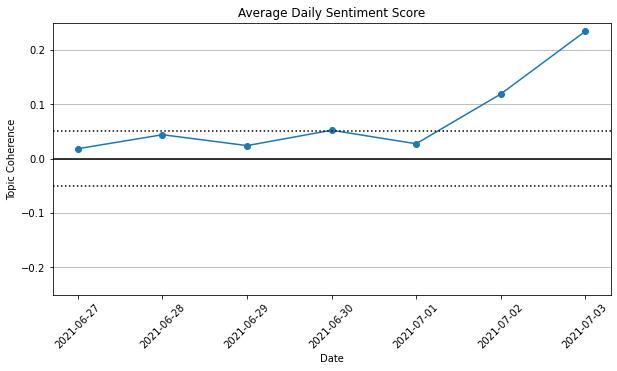

In [24]:
plt.figure(figsize=[10, 5])
plt.plot(sentiment_avg, marker='o')
plt.grid(axis = 'y')
plt.axhline(y = 0.05, color = 'black', linestyle = ':')
plt.axhline(y = 0, color = 'black', linestyle = '-')
plt.axhline(y = -0.05, color = 'black', linestyle = ':')
plt.title("Average Daily Sentiment Score")
plt.xticks(rotation = 45)
plt.xlabel('Date', fontsize = 10)
plt.ylabel('Topic Coherence', fontsize = 10)
plt.ylim([-0.25, 0.25])

# LDA Section

# Finding best K

In [25]:
def topic_coherence(model, n_top_words, pair_score):
    coherences = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        coh = 0
        for i in range(len(top_features_ind)):
            for j in range(i):
                coh += pair_score[top_features_ind[i], top_features_ind[j]]
        coherences.append(coh)
    return coherences

## Positive Data-set

In [26]:
# the vectorizer object will be used to transform text to vector form
vectorizer_pos = CountVectorizer(max_df=0.95, min_df=2)

# apply transformation
tf_pos = vectorizer_pos.fit_transform(this_data_pos['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_pos_feature_names = vectorizer_pos.get_feature_names()

# check dimensions
print(tf_pos.shape)

(136, 135)


In [27]:
Dwi = np.array(np.sum(tf_pos > 0, axis=0))[0]

W_bin = tf_pos
W_bin[W_bin > 0] = 1
Dwi_wj = W_bin.T @ W_bin

score_umass_pos = np.log((Dwi_wj.toarray() + 1)/ Dwi)

In [28]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
pos_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_pos = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_pos.fit(tf_pos)
    this_coh.append(np.median(topic_coherence(this_model_pos, 10, score_umass_pos)))
    pos_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
1.4649269580841064 seconds


In [29]:
pos_topic_cohs

[[-66.714143191036],
 [-57.52809857997678],
 [-53.690817442621125],
 [-32.11579290214239],
 [-39.90975310100823],
 [-47.48056974855985],
 [-28.072248265971467],
 [-42.04272563503812],
 [-37.33260766228449]]

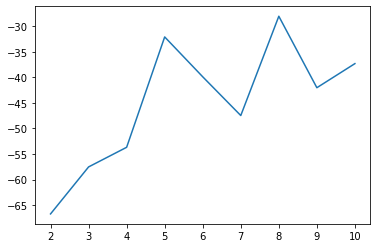

In [30]:
plt.plot(ks, pos_topic_cohs)

## Negative Data-set

In [31]:
# the vectorizer object will be used to transform text to vector form
vectorizer_neg = CountVectorizer(max_df=0.95, min_df=2) #, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf_neg = vectorizer_neg.fit_transform(this_data_neg['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_neg_feature_names = vectorizer_neg.get_feature_names()

# check dimensions
print(tf_neg.shape)

(70, 77)


In [32]:
Dwi_neg = np.array(np.sum(tf_neg > 0, axis=0))[0]

W_bin_neg = tf_neg
W_bin_neg[W_bin_neg > 0] = 1
Dwi_wj_neg = W_bin_neg.T @ W_bin_neg

score_umass_neg = np.log((Dwi_wj_neg.toarray() + 1)/ Dwi_neg)

In [33]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
neg_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_neg = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_neg.fit(tf_neg)
    this_coh.append(np.median(topic_coherence(this_model_neg, 10, score_umass_neg)))
    neg_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
0.7012748718261719 seconds


In [34]:
neg_topic_cohs

[[-55.64551481370896],
 [-25.025905509339385],
 [-33.14037486531474],
 [-38.29299396759239],
 [-27.579784723001936],
 [-32.02965540817057],
 [-29.903829315853688],
 [-32.10130279835729],
 [-34.899700615999194]]

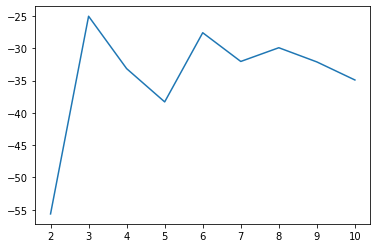

In [35]:
plt.plot(ks, neg_topic_cohs)

## Neutral Data-set

In [36]:
# the vectorizer object will be used to transform text to vector form
vectorizer_neu = CountVectorizer(max_df=0.95, min_df=2) #, token_pattern='\w+|\$[\d\.]+|\S+')

# apply transformation
tf_neu = vectorizer_neu.fit_transform(this_data_neu['clean_text']) #.toarray()

# tf_feature_names tells us what word each column in the matric represents
tf_neu_feature_names = vectorizer_neu.get_feature_names()

# check dimensions
print(tf_neu.shape)

(573, 165)


In [37]:
Dwi_neu = np.array(np.sum(tf_neu > 0, axis=0))[0]

W_bin_neu = tf_neu
W_bin_neu[W_bin_neu > 0] = 1
Dwi_wj_neu = W_bin_neu.T @ W_bin_neu

score_umass_neu = np.log((Dwi_wj_neu.toarray() + 1)/ Dwi_neu)

In [38]:
t0 = time.time()
ks = [2, 3, 4, 5, 6, 7, 8, 9, 10]
neu_topic_cohs = []
for k in ks:
    print(f'running k = {k}')
    this_coh = []
    this_model_neu = LatentDirichletAllocation(n_components=k, random_state=0)
    this_model_neu.fit(tf_neu)
    this_coh.append(np.median(topic_coherence(this_model_neu, 10, score_umass_neu)))
    neu_topic_cohs.append(this_coh)
    
t1 = time.time()

total = t1-t0
print(total, 'seconds')

running k = 2
running k = 3
running k = 4
running k = 5
running k = 6
running k = 7
running k = 8
running k = 9
running k = 10
4.955804109573364 seconds


In [39]:
neu_topic_cohs

[[-89.30019073484213],
 [-85.2467149488301],
 [-80.10025880733063],
 [-85.2467149488301],
 [-62.33202819724717],
 [-79.27794245330664],
 [-81.82069312211758],
 [-74.95380266583116],
 [-74.0210682531501]]

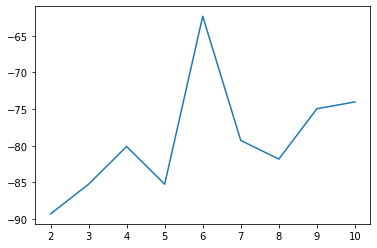

In [40]:
plt.plot(ks, neu_topic_cohs)

# Running on best k

Text(0, 0.5, 'Topic Coherence')

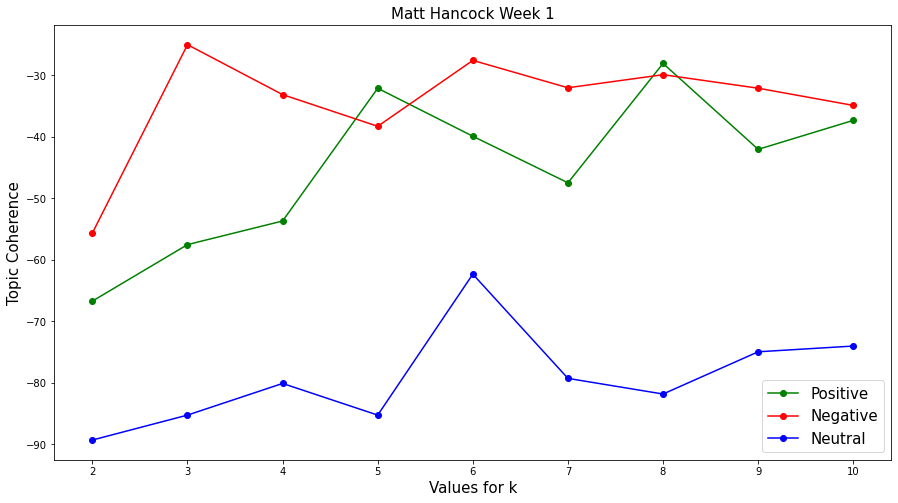

In [41]:
plt.figure(figsize=[15, 8])
plt.title("Matt Hancock Week 1", fontsize = 15)
plt.plot(ks, pos_topic_cohs, label = 'Positive', marker='o', color = 'g')
plt.plot(ks, neg_topic_cohs, label = 'Negative', marker='o', color = 'r')
plt.plot(ks, neu_topic_cohs, label = 'Neutral', marker='o', color = 'b')
plt.legend(prop={"size":15})
plt.xlabel('Values for k', fontsize = 15)
plt.ylabel('Topic Coherence', fontsize = 15)


In [42]:
def plot_top_words(model, feature_names, n_top_words, title):
    """Function to plot topic models"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 20})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

## Positive Data-Set

In [43]:
# Choose based on above results
number_of_topics = 5
n_top_words = 10

In [44]:
# model
model_pos = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_pos.fit(tf_pos)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

0.13429021835327148 seconds


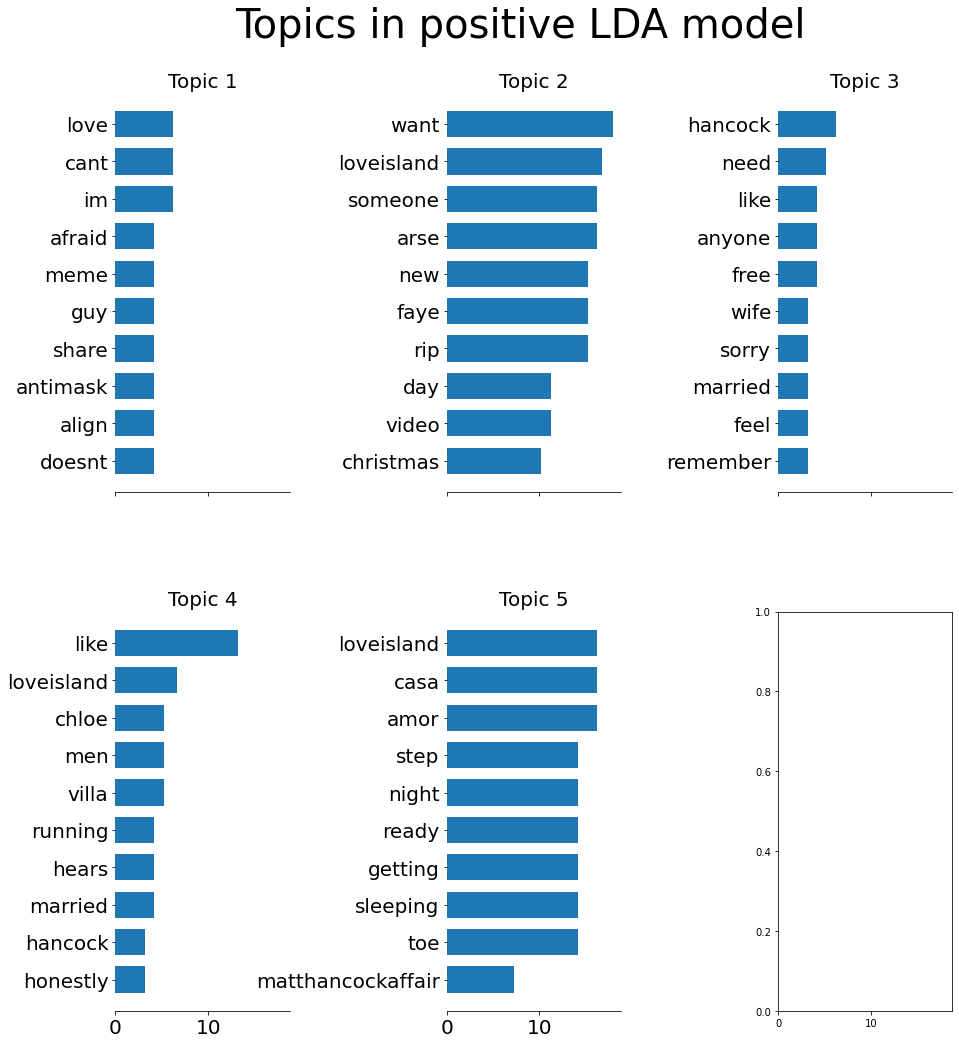

In [45]:
# Names of words 
plot_top_words(model_pos, tf_pos_feature_names, n_top_words, 'Topics in positive LDA model')

## Negative Data-Set

In [46]:
# Choose based on above results
number_of_topics = 3
n_top_words = 10

In [47]:
# model
model_neg = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_neg.fit(tf_neg)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

0.08064818382263184 seconds


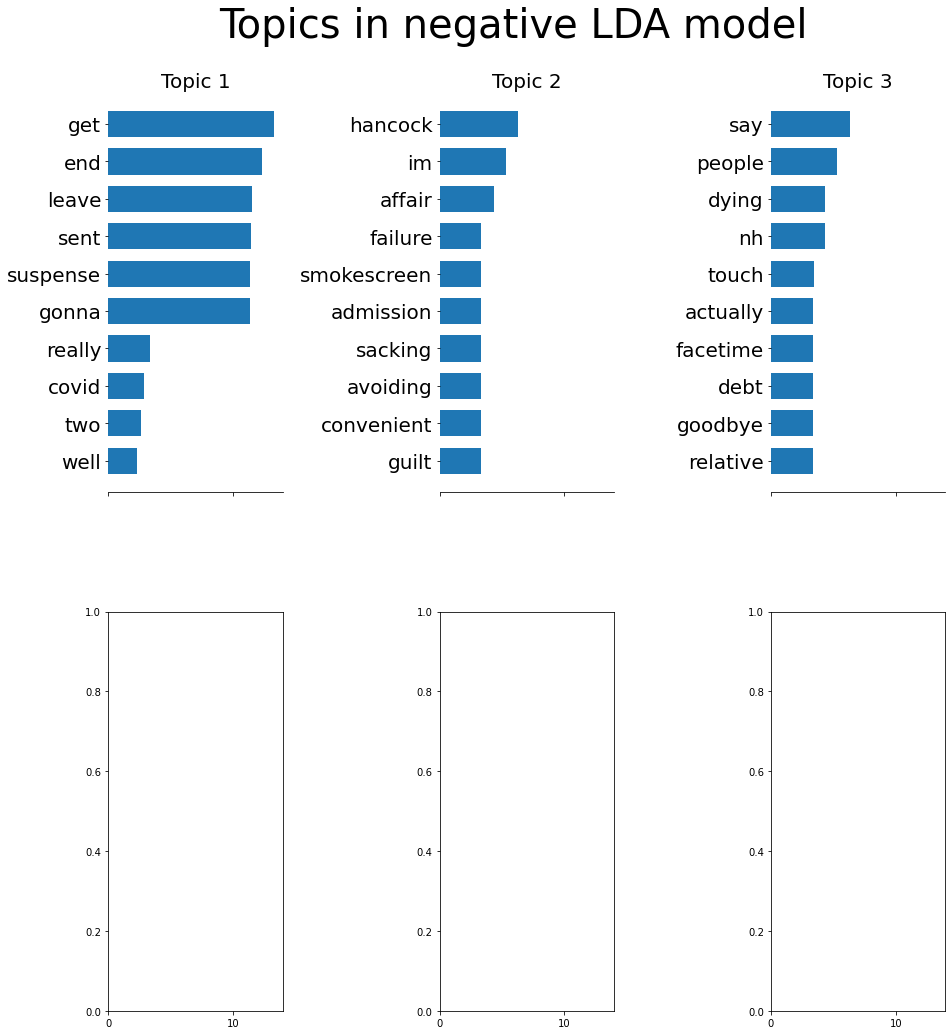

In [48]:
# Names of words 
plot_top_words(model_neg, tf_neg_feature_names, n_top_words, 'Topics in negative LDA model')

## Neutral Data-Set

In [49]:
# Choose based on above results
number_of_topics = 4
n_top_words = 10

In [50]:
# model
model_neu = LatentDirichletAllocation(n_components=number_of_topics, random_state=0) # random state for reproducibility

# Fit data to model
t0 = time.time()
model_neu.fit(tf_neu)
t1 = time.time()

total = t1-t0
print(total, 'seconds') #note: 615.2014217376709 seconds

0.5078439712524414 seconds


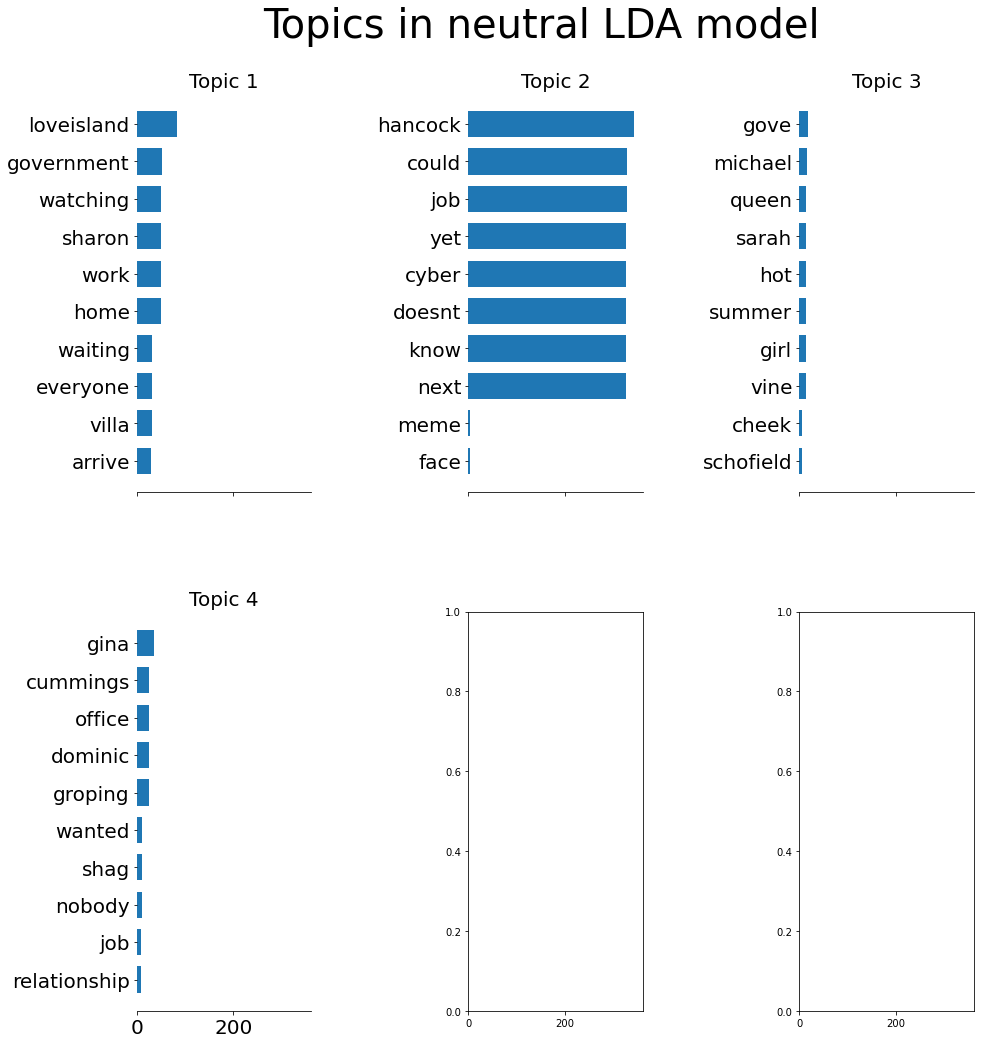

In [51]:
# Names of words 
plot_top_words(model_neu, tf_neu_feature_names, n_top_words, 'Topics in neutral LDA model')